In [1]:
import cartopy
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib notebook

sys.path.append("../marinetraffic/")

from vesseltracks import read_vesseltracks_file

In [2]:
def to_int(string):
    try:
        return int(string)
    except Exception as e:
        print(f'failed to convert to int: {string} {e}')
        return 0
    
windfarms = pd.read_csv("windfarms.csv")
windfarms.set_index('index', inplace=True)
windfarms.commissioning = windfarms.commissioning.apply(to_int)

failed to convert to int: nan cannot convert float NaN to integer
failed to convert to int: nan cannot convert float NaN to integer
failed to convert to int: nan cannot convert float NaN to integer
failed to convert to int: 1997/2018 invalid literal for int() with base 10: '1997/2018'
failed to convert to int: — invalid literal for int() with base 10: '—'
failed to convert to int: — invalid literal for int() with base 10: '—'


In [3]:
def get_cluster_coord_year(basedir, min_locations=6):
    for vesseldir in glob.glob(os.path.join(basedir, "*")):
        vesselname = os.path.basename(vesseldir)
        # print(f"processing {vesselname}")
        for clusterdir in glob.glob(os.path.join(vesseldir, "cluster_*")):
            clustername = os.path.basename(clusterdir)
            # print(f"processing {clustername}")
            if (n_locations := len(glob.glob(os.path.join(clusterdir, "*location_*.csv")))) < 6:
                print(f"only {n_locations} single locations available at {clusterdir}, skipping")
                continue
            if os.path.isfile(cluster_fpath := os.path.join(clusterdir, f"{vesselname}_{clustername}.csv")):
                #print(cluster_fpath)
                cluster = read_vesseltracks_file(cluster_fpath)
                lat_mean = cluster.latitude.mean()
                lon_mean = cluster.longitude.mean()
                year = cluster.index[-1].year
                yield (vesselname, clustername, lat_mean, lon_mean, year)

In [13]:
def match_cluster_windfarm(clustered_vesseltracks_dir, windfarms, lower_bound=0.025, upper_bound=0.025, verbose=False):
    for (vesselname, clustername, cluster_lat, cluster_lon, cluster_year) in get_cluster_coord_year(clustered_vesseltracks_dir):
        for windfarm in windfarms.itertuples():
            #print(windfarm)
            #print(windfarm["name"], windfarm.latitude, windfarm.longitude)
            lat_lower = windfarm.latitude - lower_bound
            lat_upper = windfarm.latitude + upper_bound
            lon_lower = windfarm.longitude - lower_bound
            lon_upper = windfarm.longitude + upper_bound
            if lat_lower < cluster_lat < lat_upper and lon_lower < cluster_lon < lon_upper and cluster_year <= windfarm.commissioning:
                if verbose:
                    print(f"found possible match: {windfarm.Index} {windfarm.name}: {vesselname}/{clustername}")
                yield (windfarm.Index, windfarm.name, vesselname, clustername, cluster_lat, cluster_lon)

In [6]:
def plot_cluster(
    vessel_tracks: pd.DataFrame,
    windfarm,
    title : str = "",
    label : str = "",
    margin : float = 0.1,
    figsize : tuple =(9, 9),
    save_fig="",
    verbose=False,
    transparent=True,
    show_fig=False,
):
    figure = plt.figure(figsize=figsize)
    if transparent:
        figure.patch.set_alpha(0)
    min_lat = vessel_tracks.latitude.min() - margin
    max_lat = vessel_tracks.latitude.max() + margin
    min_lon = vessel_tracks.longitude.min() - margin
    max_lon = vessel_tracks.longitude.max() + margin
    if verbose:
        print(
            f"min_lat: {min_lat} min_lon: {min_lon} max_lat: {max_lat} max_lon: {max_lon}"
        )
    ax = figure.add_subplot(1,1,1, projection=cartopy.crs.Mercator())
    ax.set_extent([min_lon, max_lon, min_lat, max_lat])
    ax.add_feature(cartopy.feature.BORDERS)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.coastlines(resolution='10m')
    plt.scatter(vessel_tracks['longitude'], vessel_tracks['latitude'], transform=cartopy.crs.PlateCarree(), label=label, color="gray", alpha=0.25, s=75)
    plt.scatter(windfarm.longitude, windfarm.latitude, color='tab:red', transform=cartopy.crs.PlateCarree(), label=windfarm["name"])
    plt.scatter(vessel_tracks.longitude.mean(), vessel_tracks.latitude.mean(), transform=cartopy.crs.PlateCarree(), label="vessel tracks centroid", color='tab:green')
    plt.legend()
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig, dpi=300)
    if show_fig:
        plt.show()

In [14]:
matching_windfarms = pd.DataFrame(data=match_cluster_windfarm("../../data/marinetraffic/clustered/", windfarms, verbose=True), columns=["windfarm_index", "windfarm_name", "vesselname", "clustername", "cluster_lat", "cluster_lon"])
matching_windfarms.index.name = 'index'

found possible match: 49 Northwind: 246777000_mpi-resolution/cluster_4
only 2 single locations available at ../../data/marinetraffic/clustered/246777000_mpi-resolution/cluster_18, skipping
found possible match: 64 Nordergründe: 246777000_mpi-resolution/cluster_7
found possible match: 44 Lincs: 246777000_mpi-resolution/cluster_1
only 5 single locations available at ../../data/marinetraffic/clustered/246777000_mpi-resolution/cluster_8, skipping
only 4 single locations available at ../../data/marinetraffic/clustered/246777000_mpi-resolution/cluster_15, skipping
found possible match: 54 Humber Gateway: 246777000_mpi-resolution/cluster_5
only 1 single locations available at ../../data/marinetraffic/clustered/246777000_mpi-resolution/cluster_6, skipping
found possible match: 263 Beleolico *: 246777000_mpi-resolution/cluster_19
only 4 single locations available at ../../data/marinetraffic/clustered/215644000_blue-tern/cluster_1, skipping
only 2 single locations available at ../../data/marinet

<IPython.core.display.Javascript object>


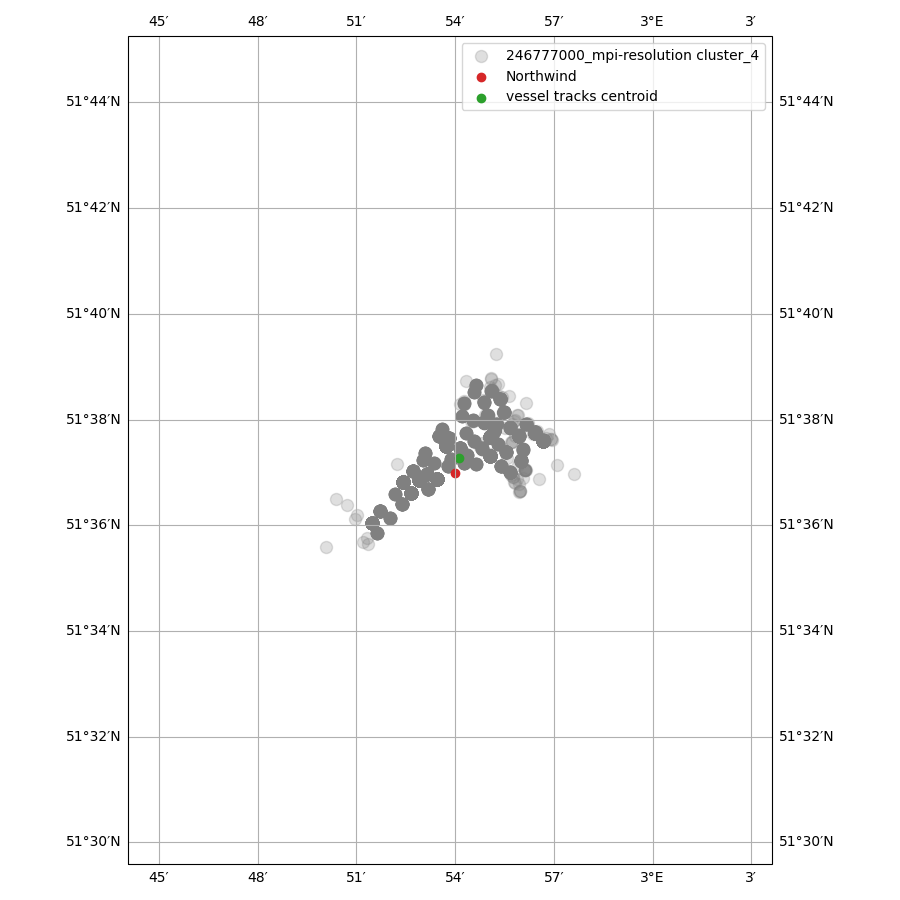

<IPython.core.display.Javascript object>


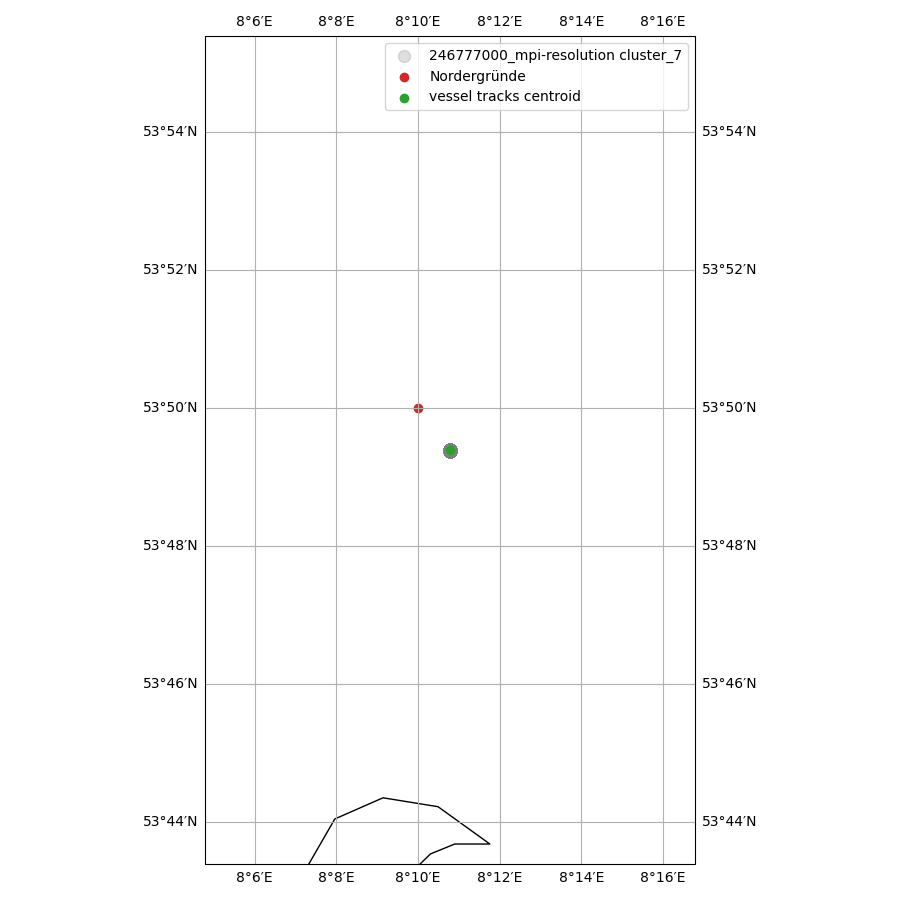

<IPython.core.display.Javascript object>


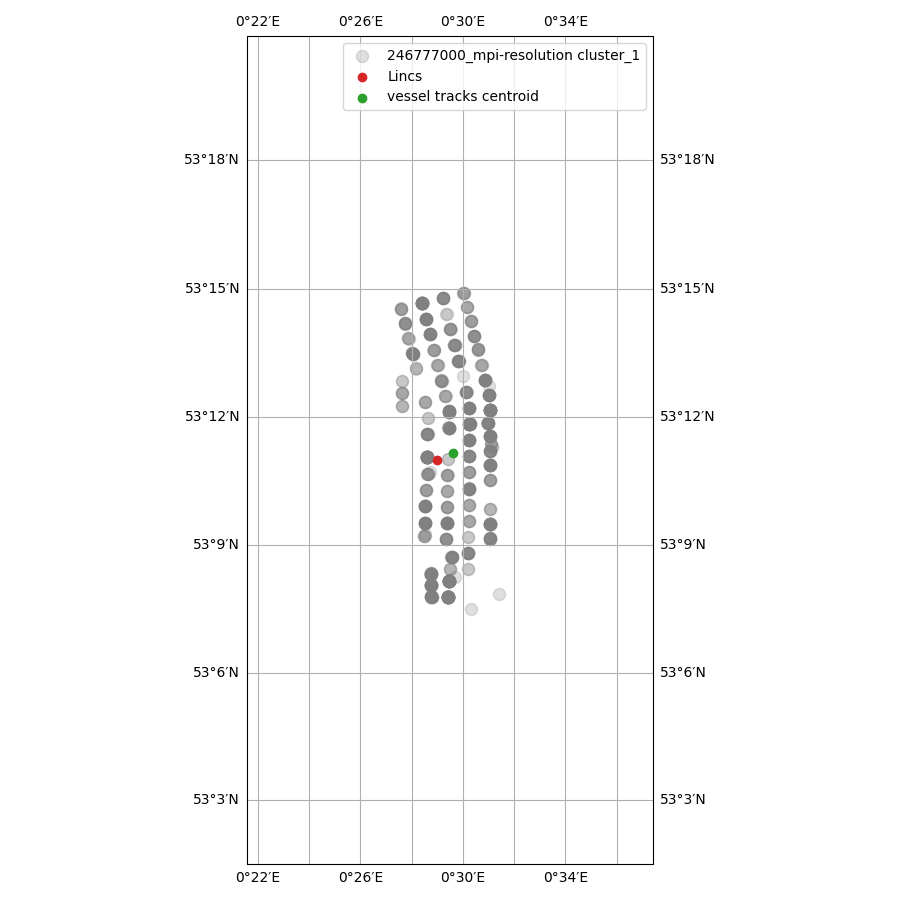

<IPython.core.display.Javascript object>


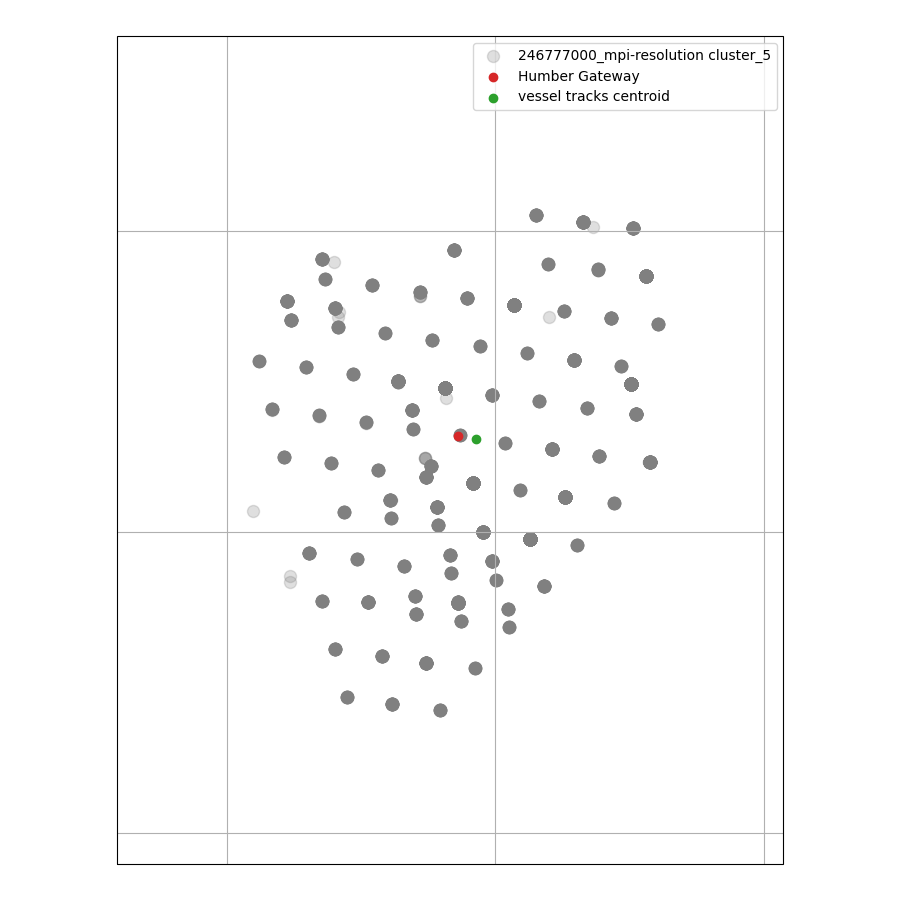

<IPython.core.display.Javascript object>


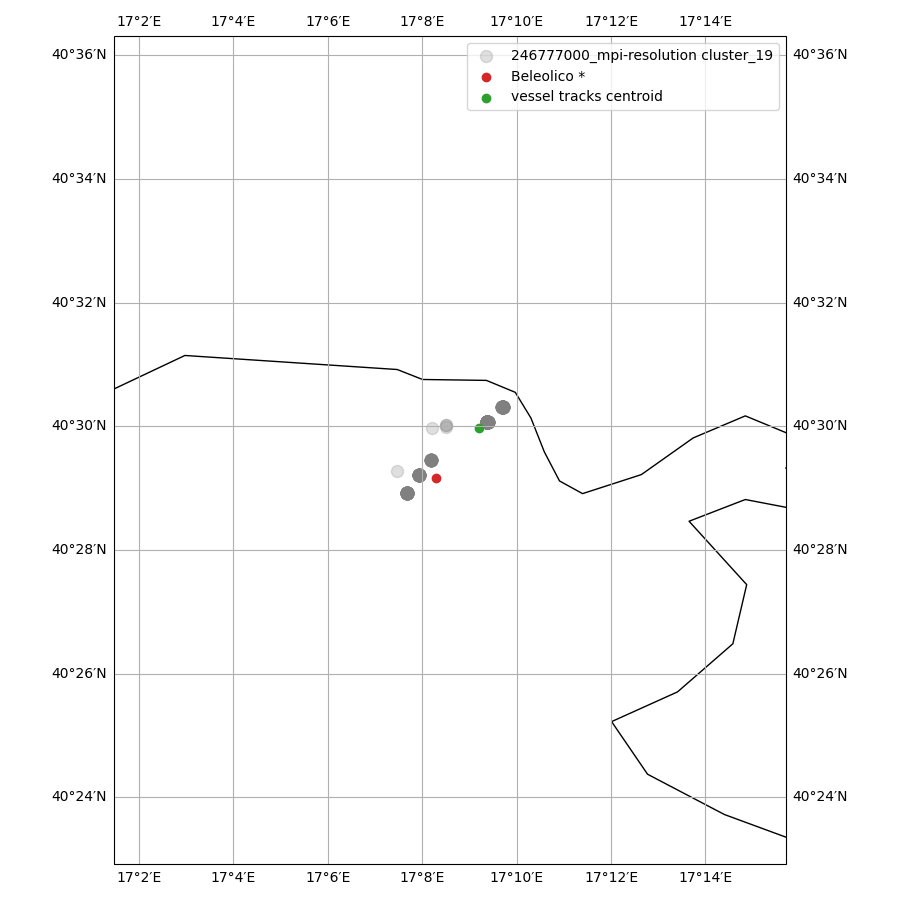

<IPython.core.display.Javascript object>


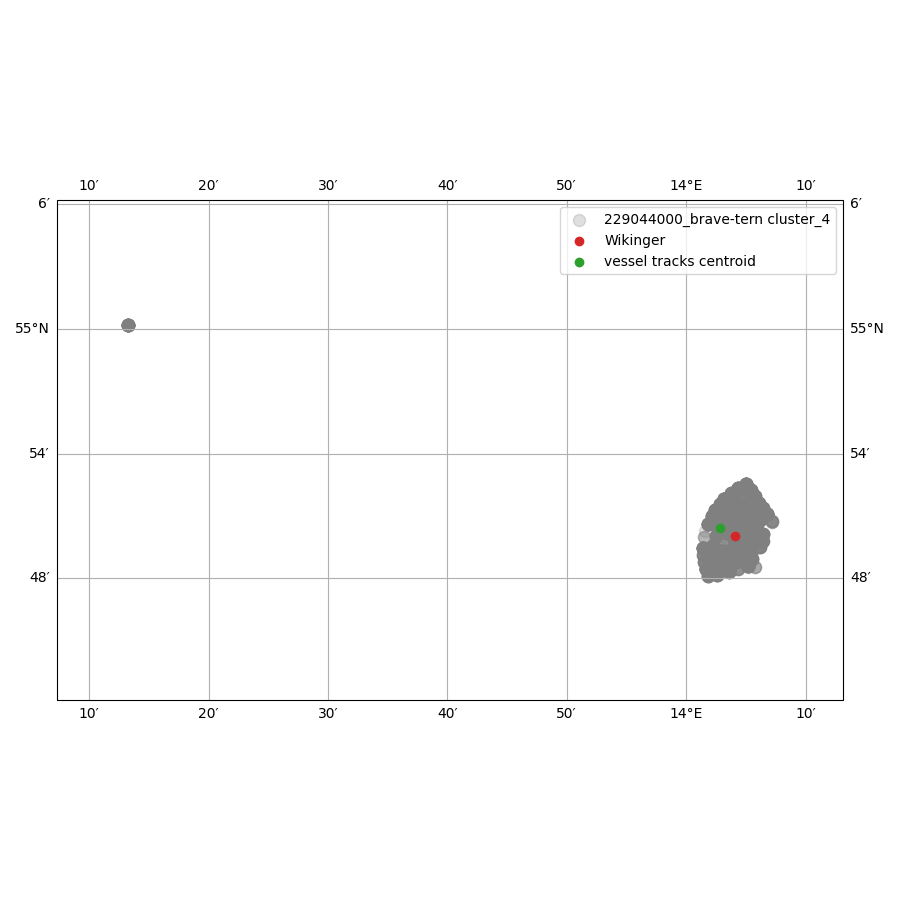

<IPython.core.display.Javascript object>


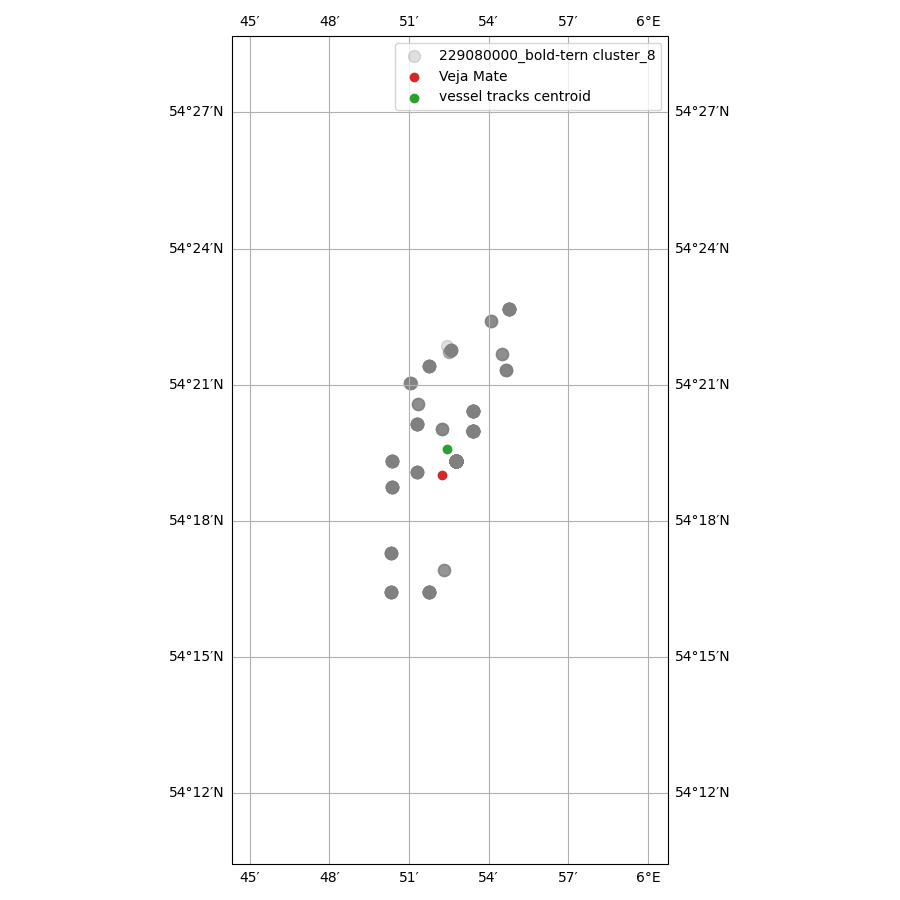

<IPython.core.display.Javascript object>


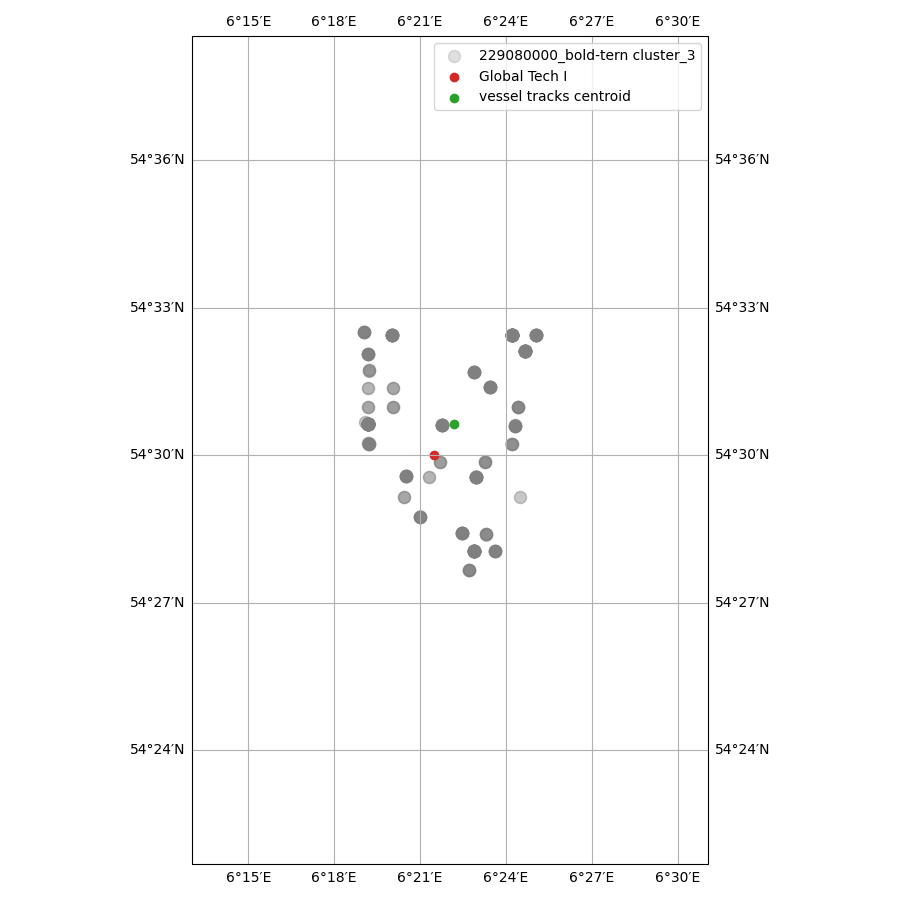

<IPython.core.display.Javascript object>


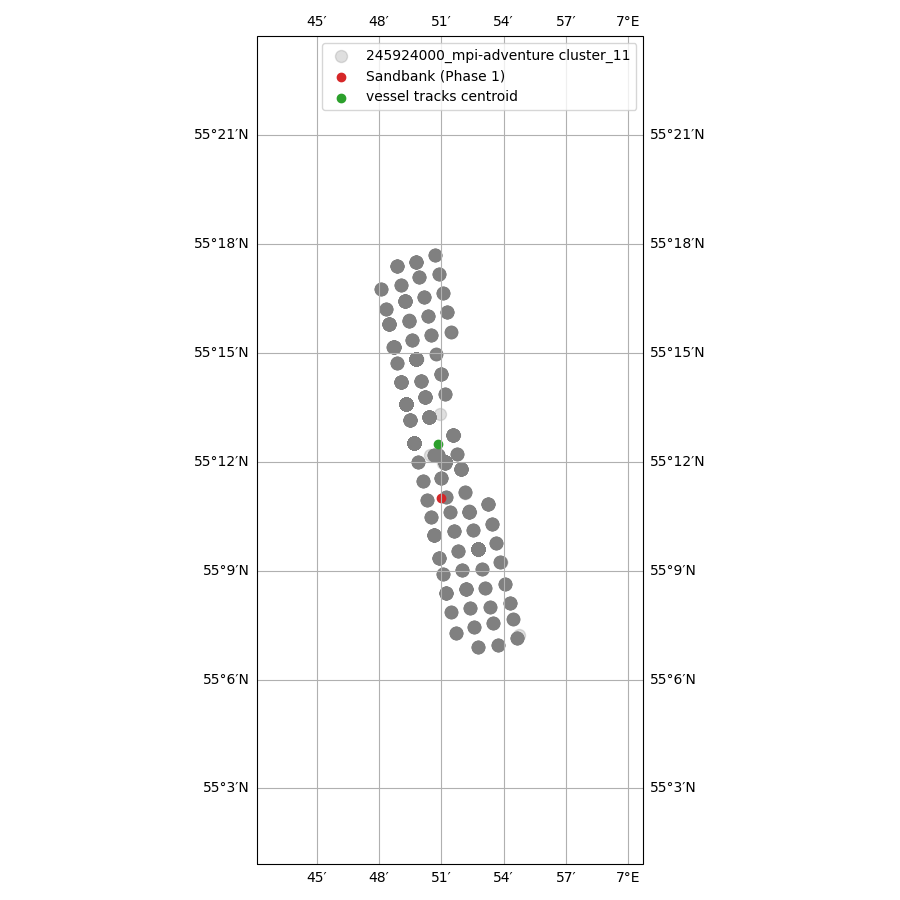

<IPython.core.display.Javascript object>


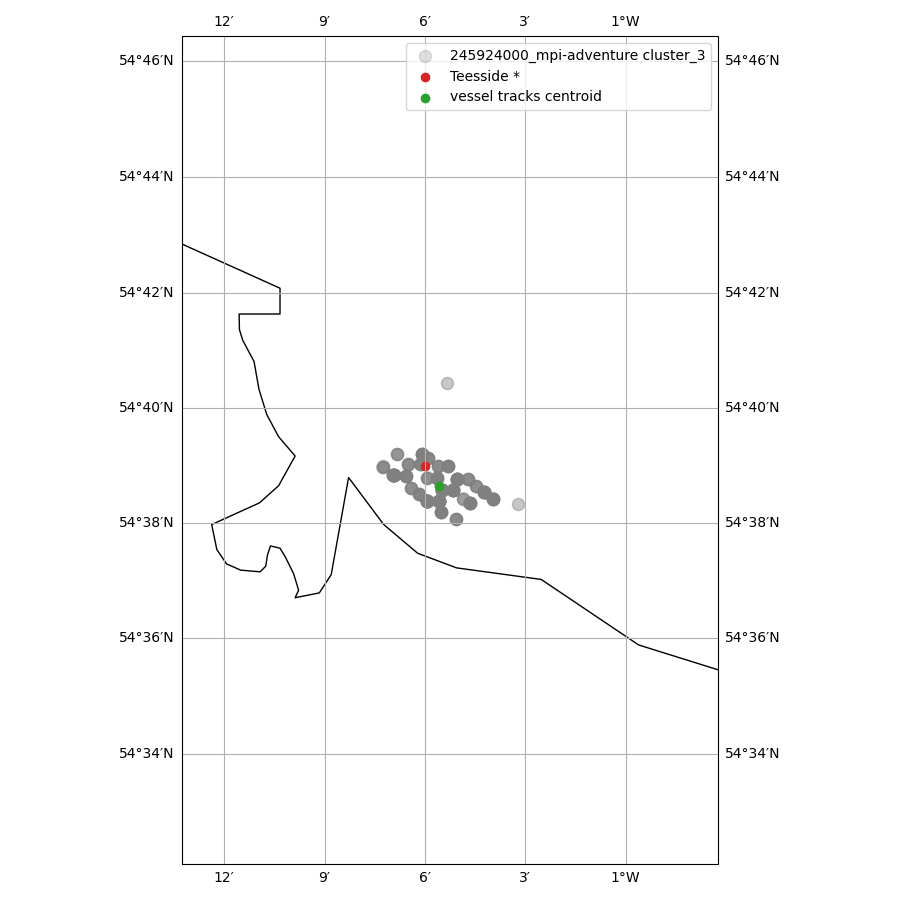

<IPython.core.display.Javascript object>


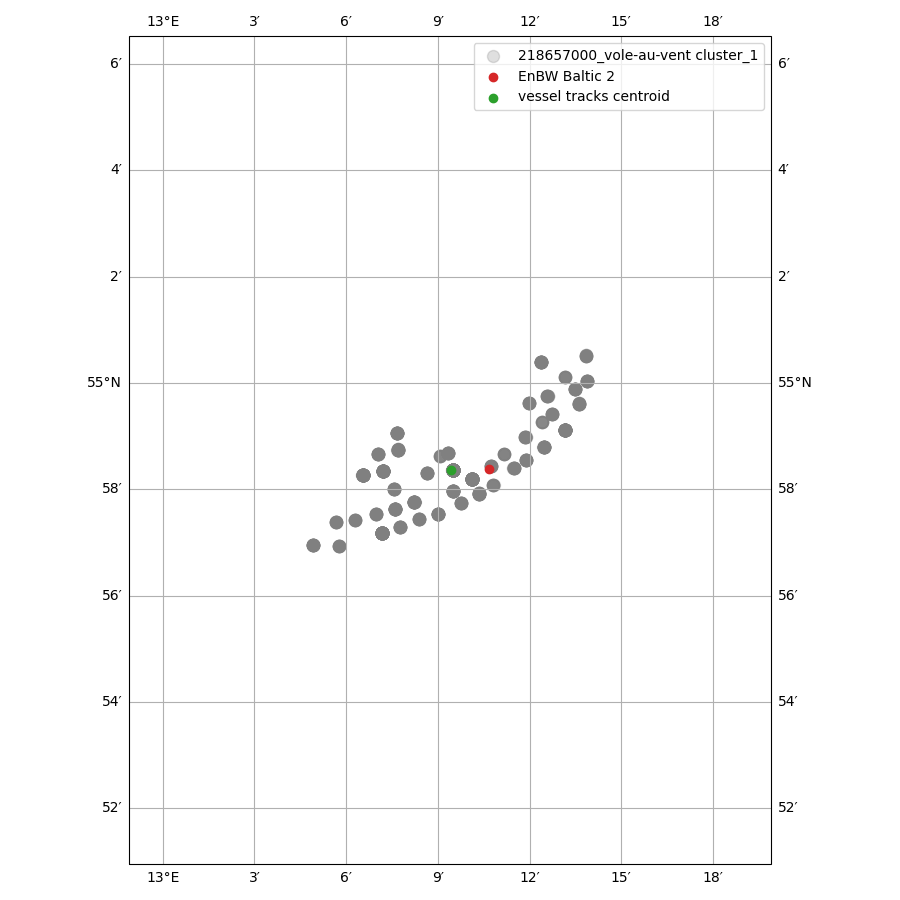

<IPython.core.display.Javascript object>


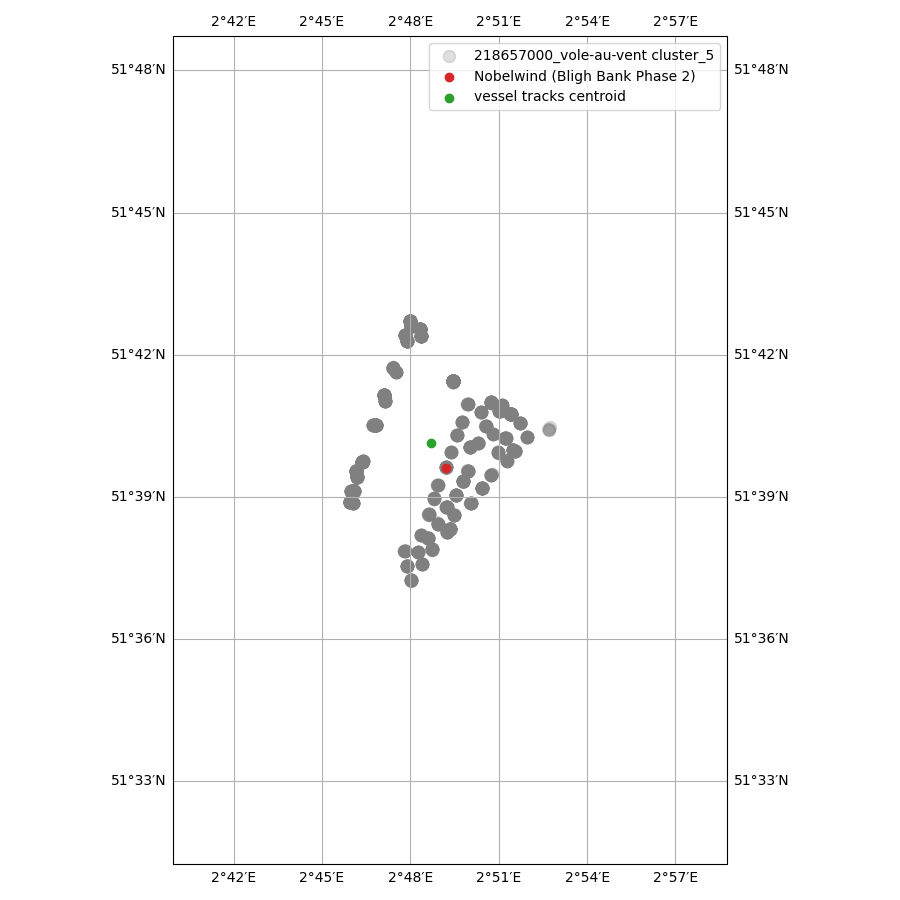

<IPython.core.display.Javascript object>


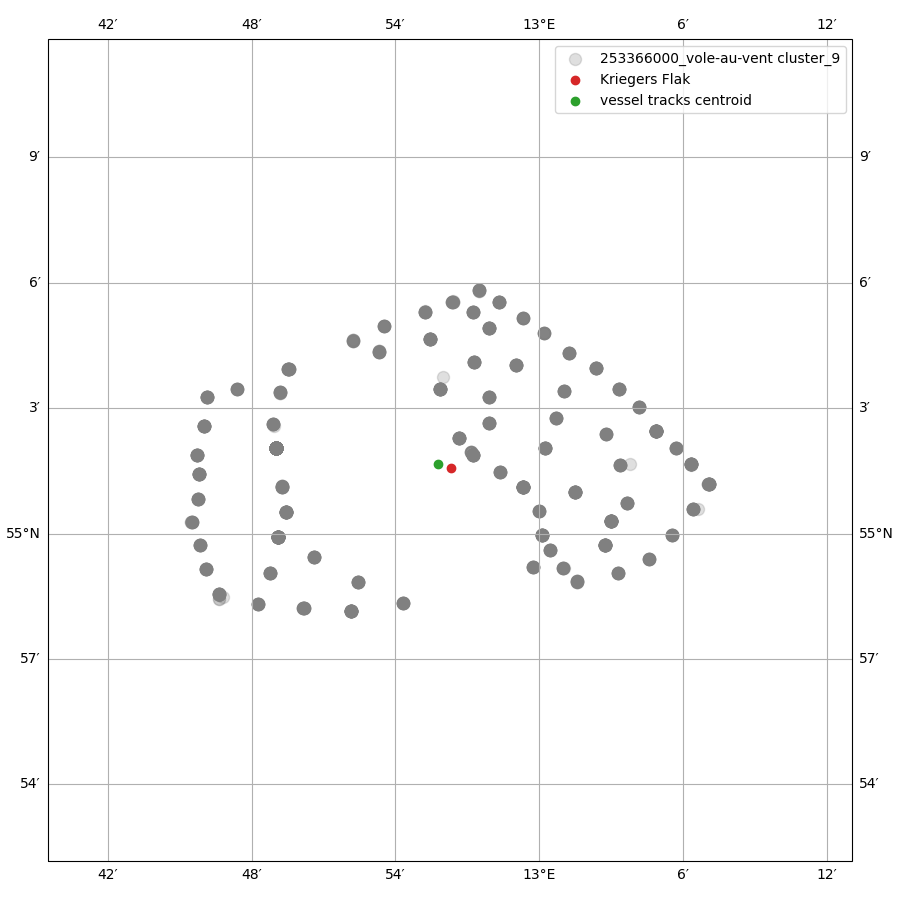

<IPython.core.display.Javascript object>


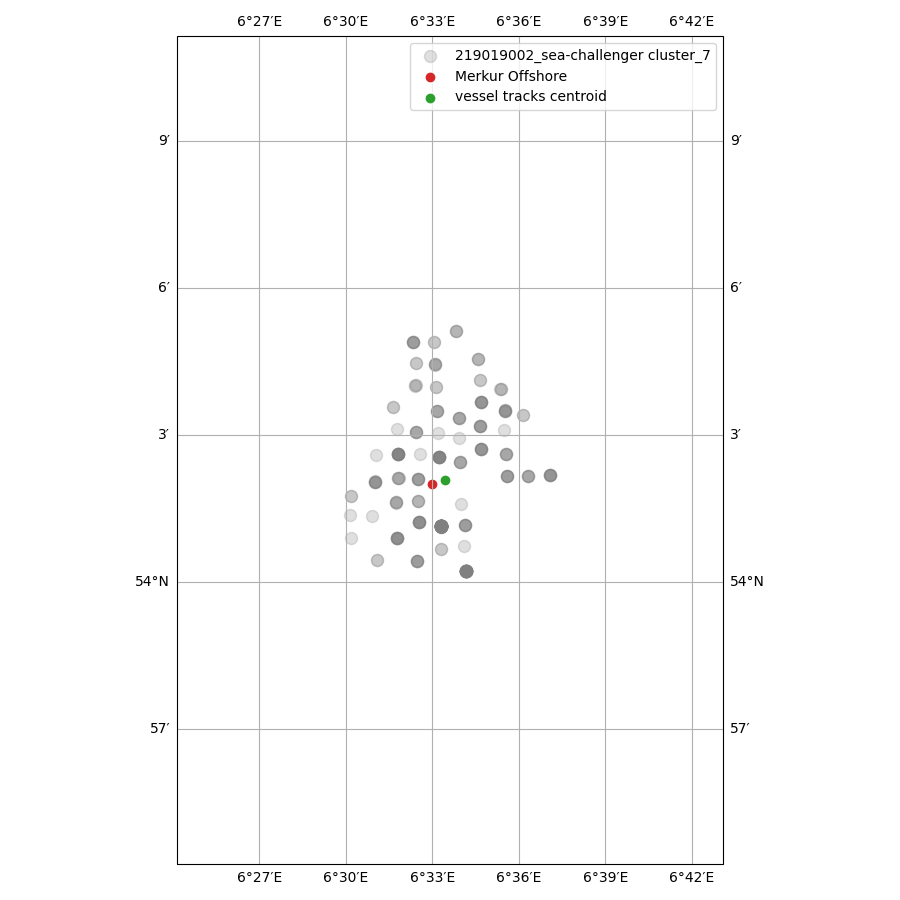

<IPython.core.display.Javascript object>


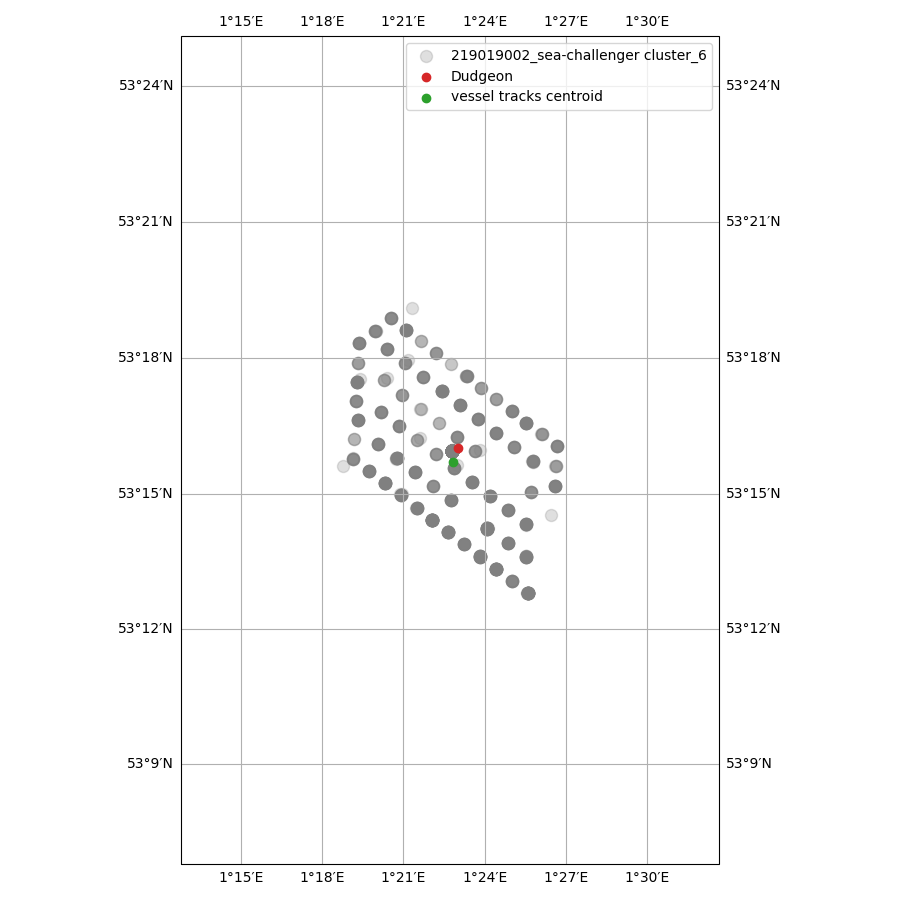

<IPython.core.display.Javascript object>


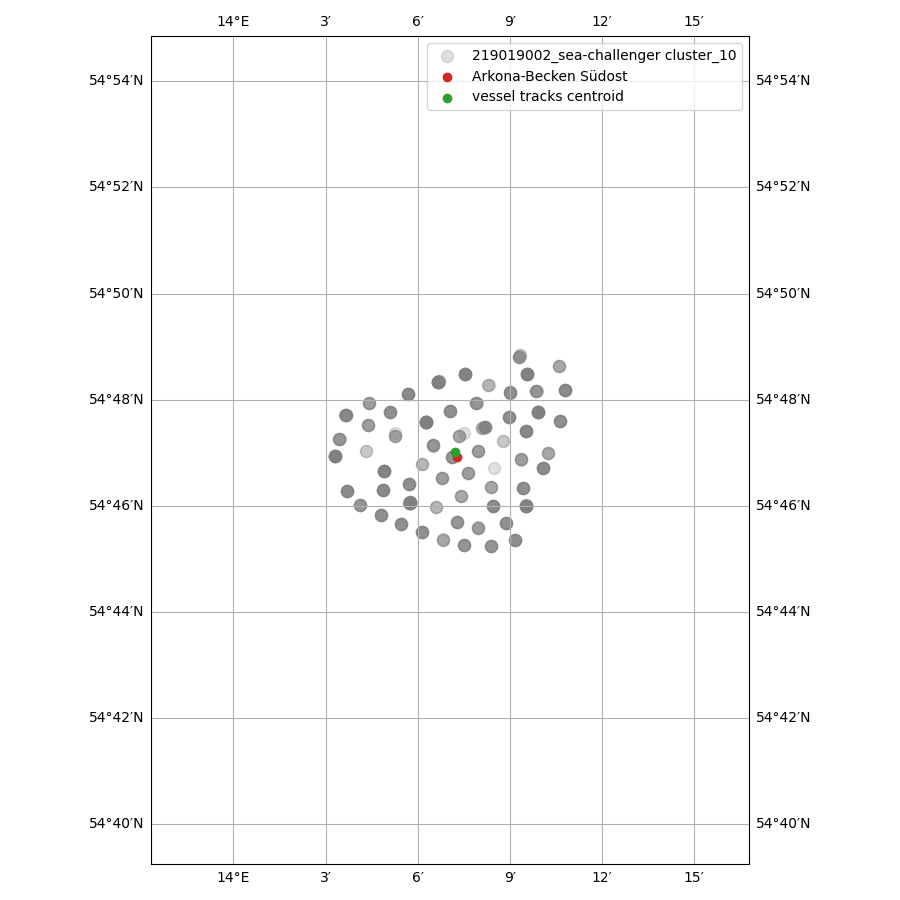

<IPython.core.display.Javascript object>


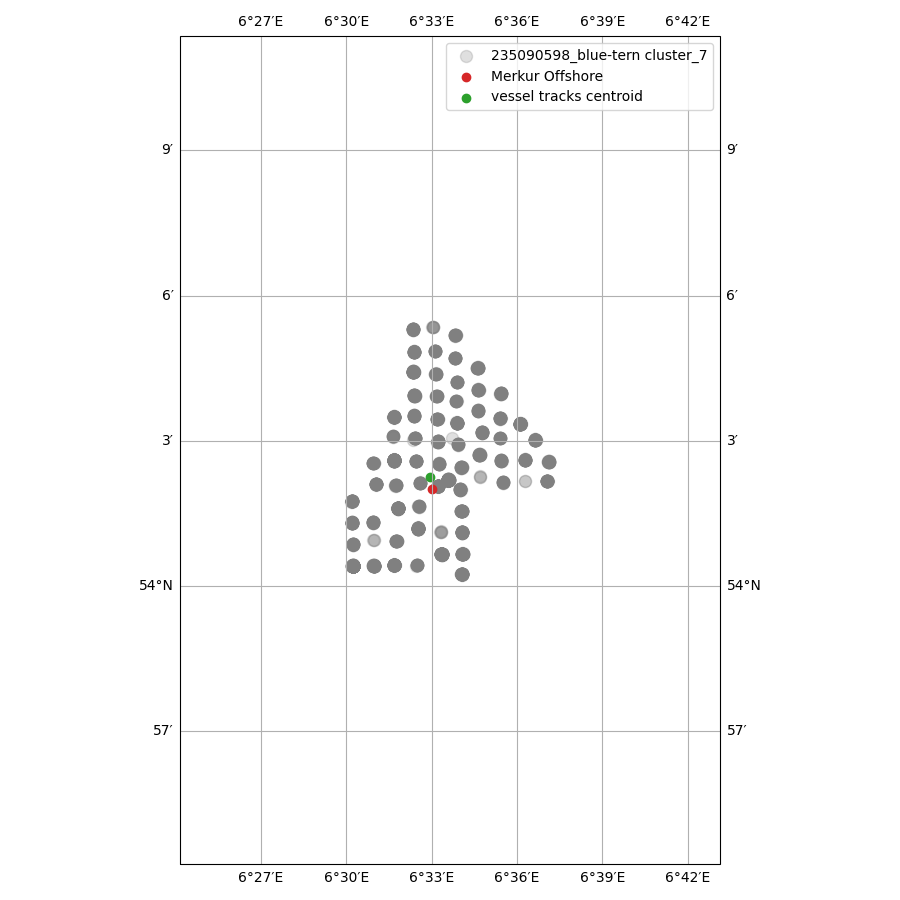

<IPython.core.display.Javascript object>


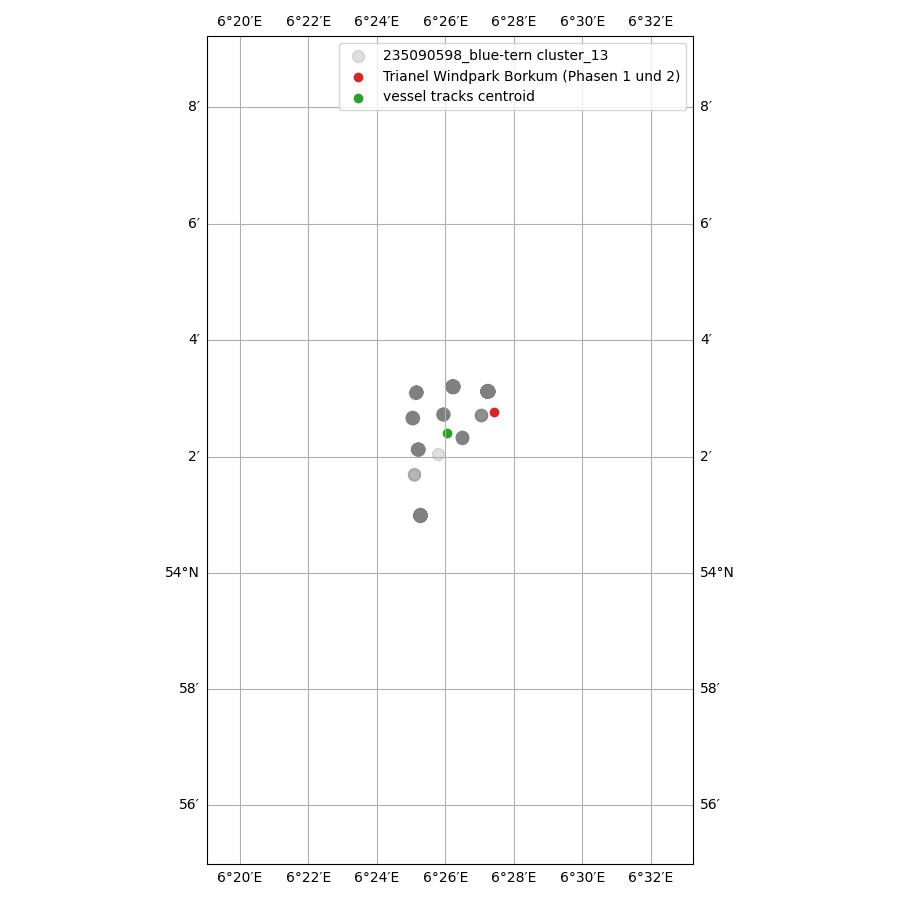

<IPython.core.display.Javascript object>


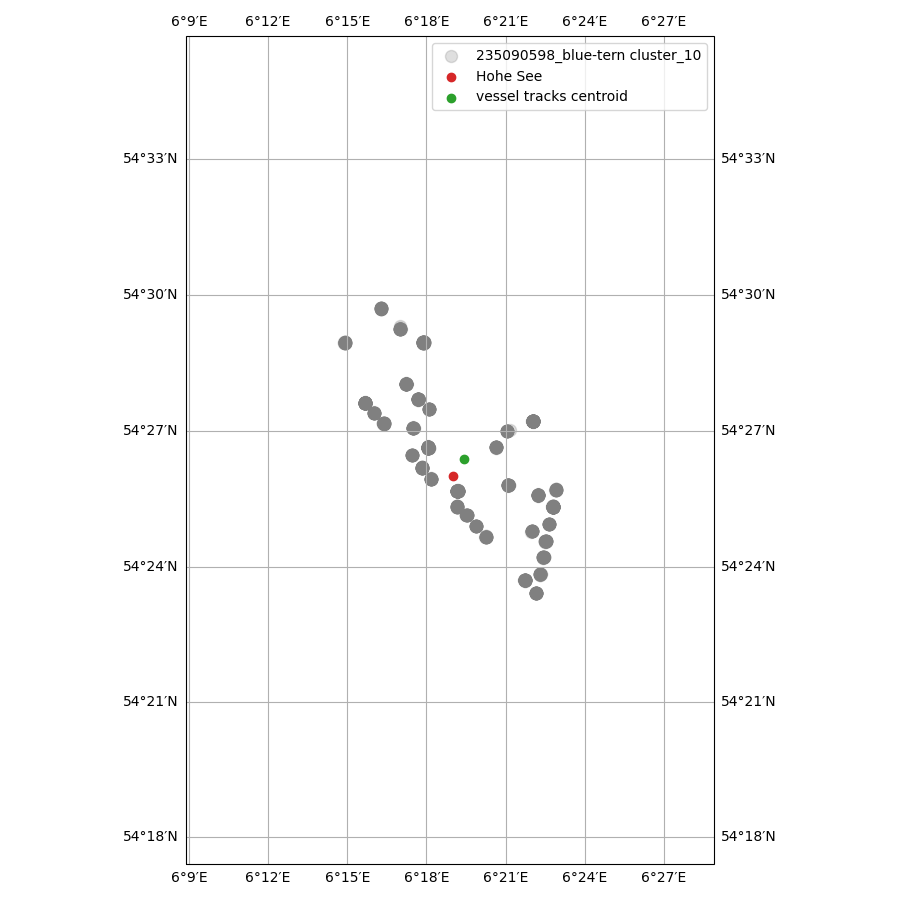

<IPython.core.display.Javascript object>


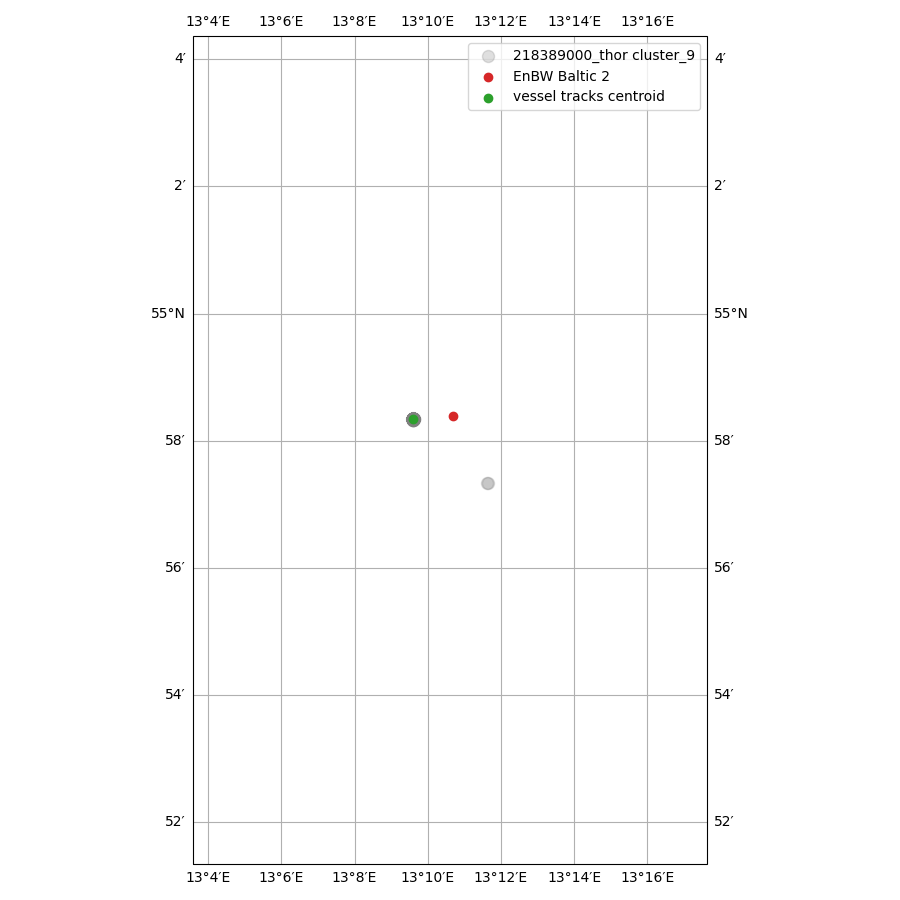

/tmp/ipykernel_435197/3568849045.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figsize=figsize)


<IPython.core.display.Javascript object>


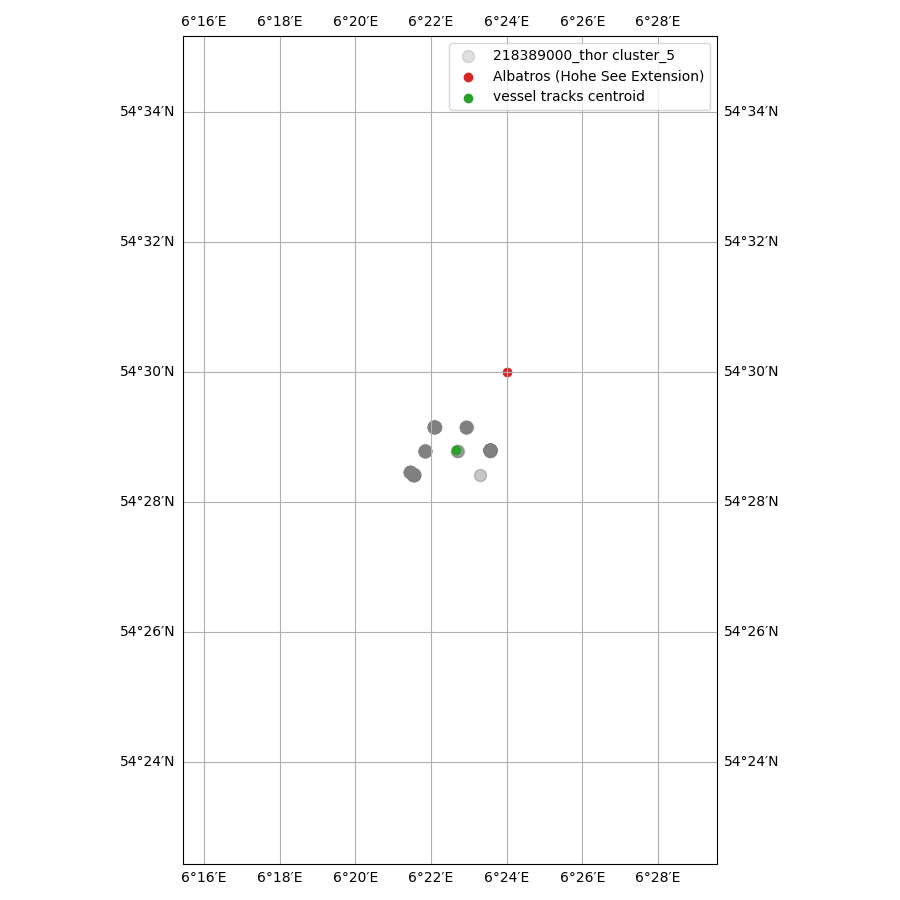

<IPython.core.display.Javascript object>


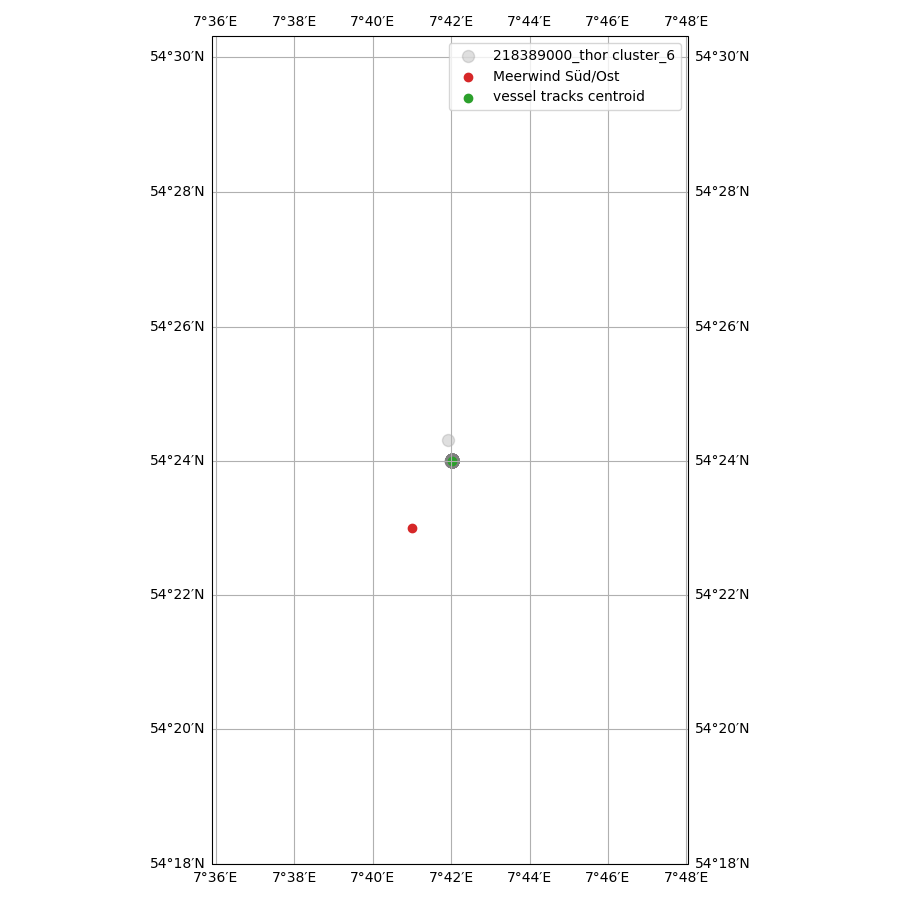

<IPython.core.display.Javascript object>


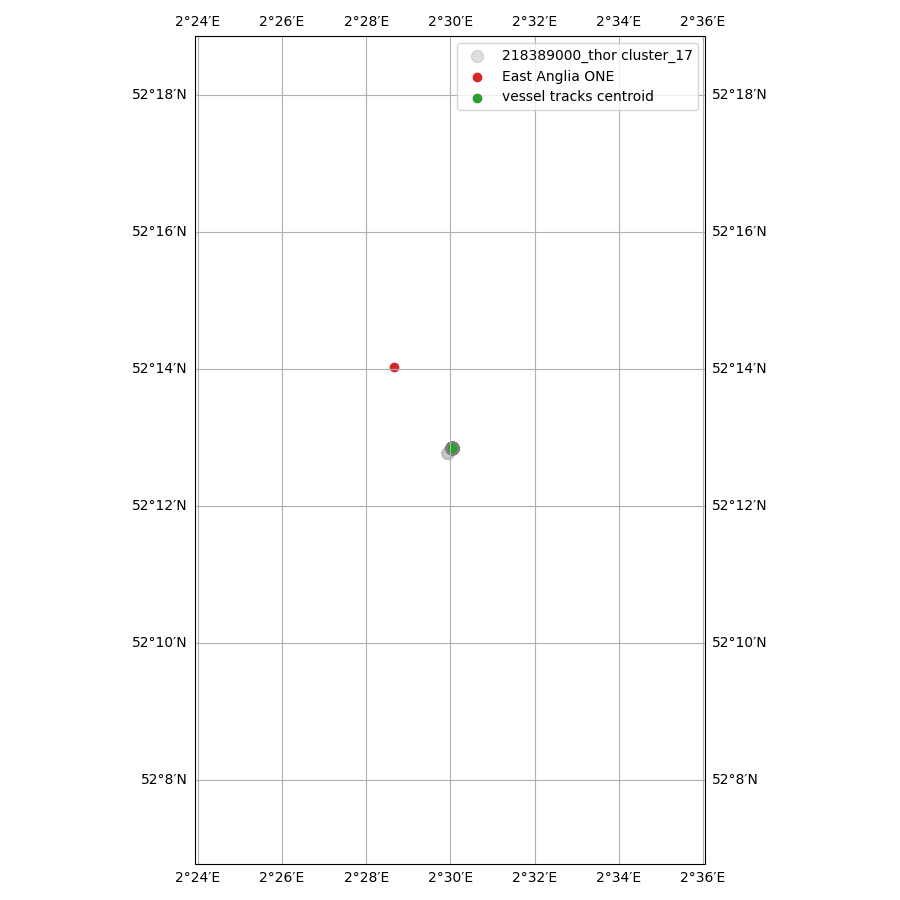

<IPython.core.display.Javascript object>


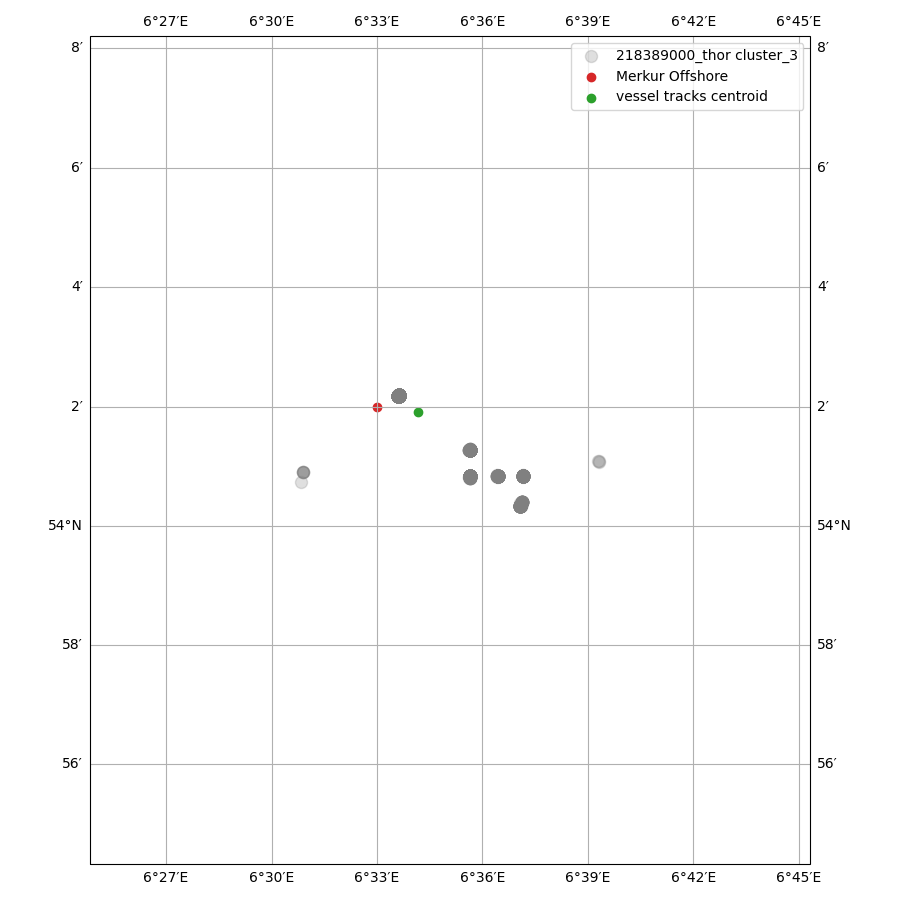

<IPython.core.display.Javascript object>


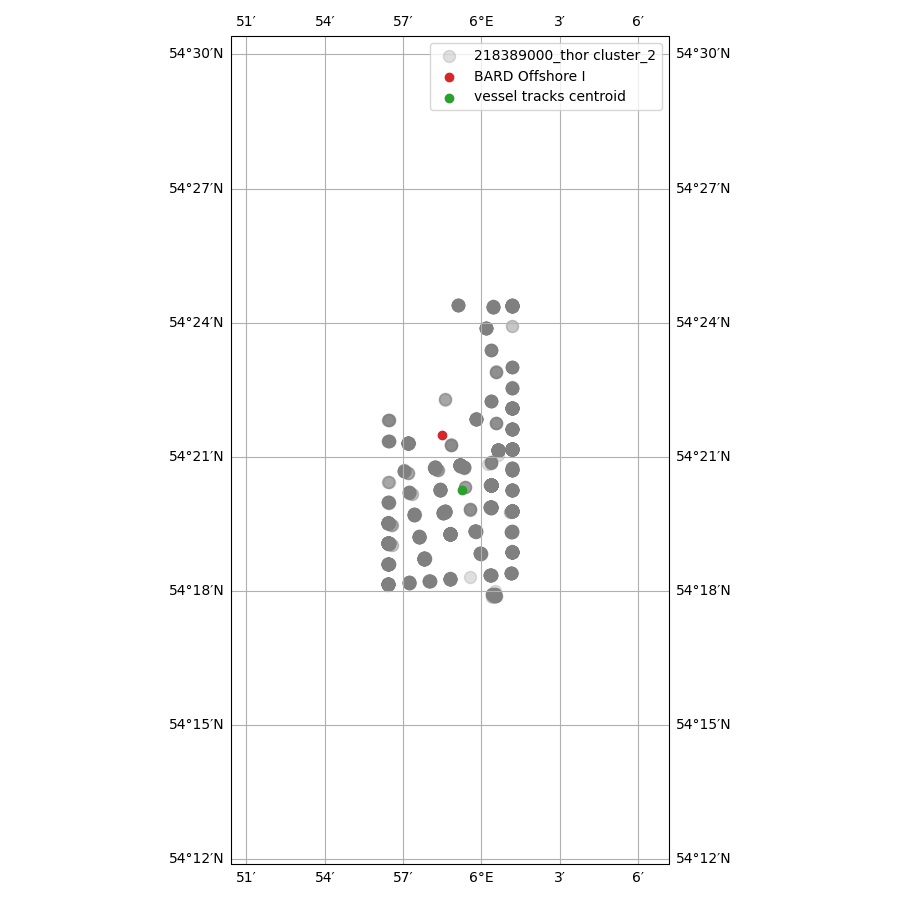

<IPython.core.display.Javascript object>


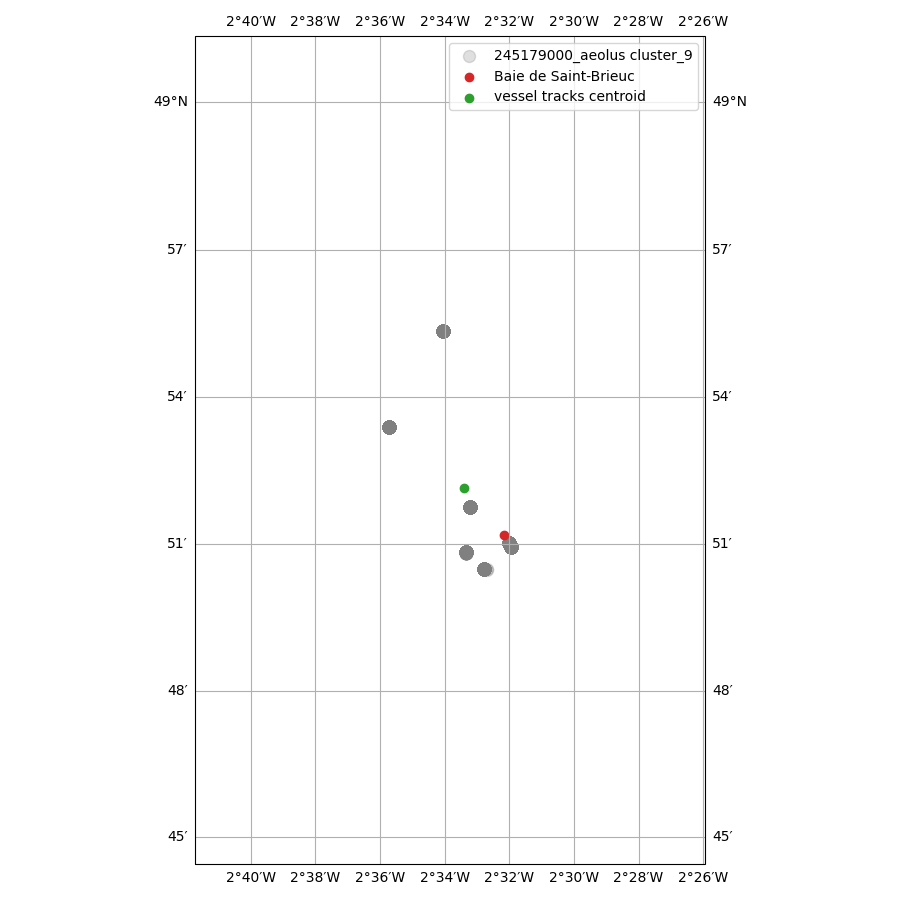

<IPython.core.display.Javascript object>


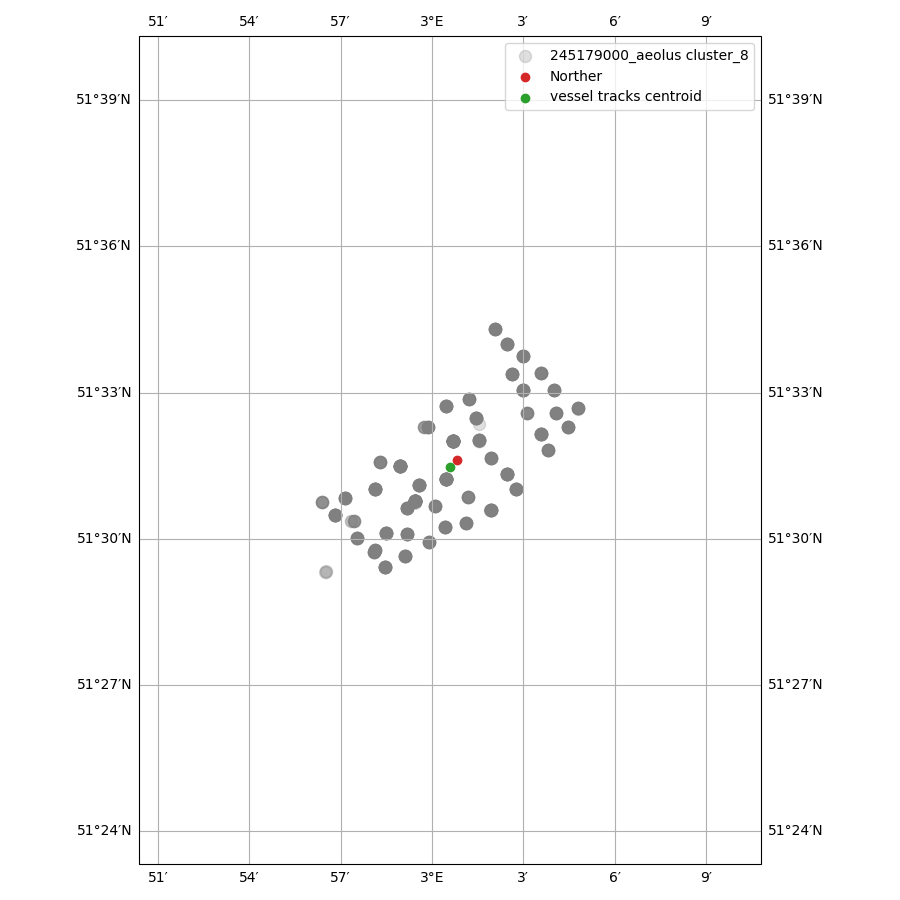

<IPython.core.display.Javascript object>


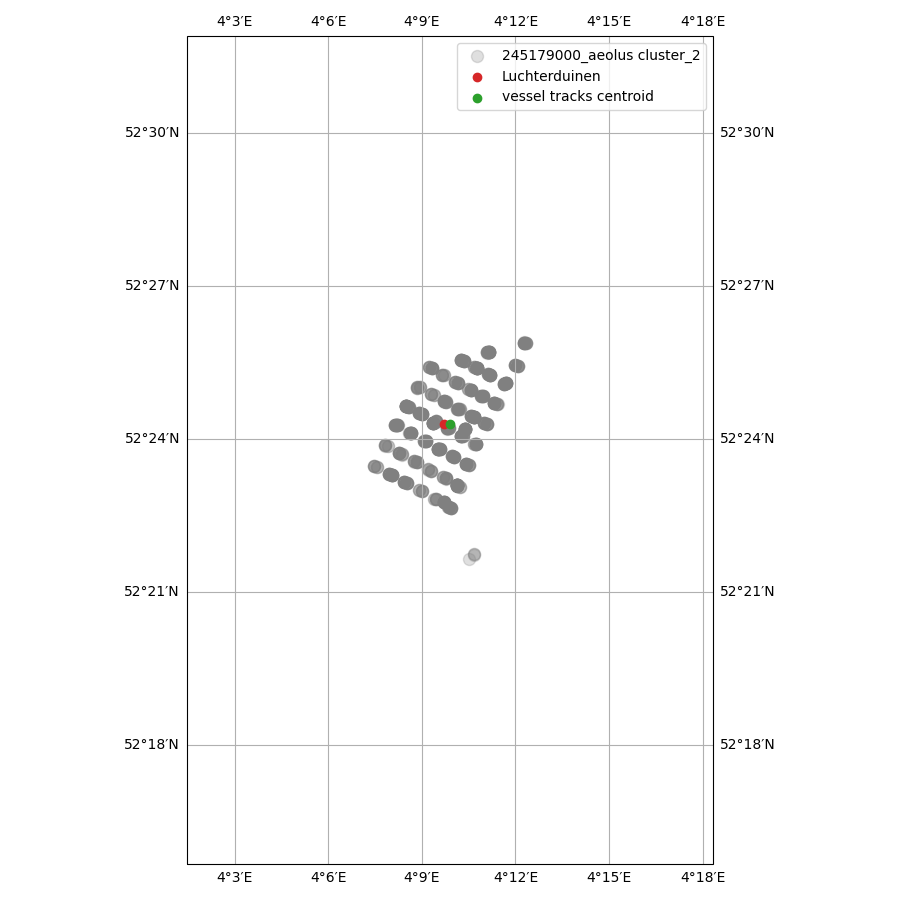

In [15]:
basedir = "../../data/marinetraffic/clustered/"
for _, matching_windfarm in matching_windfarms.iterrows():
    clusterpath = os.path.join(os.path.join(os.path.join(basedir, matching_windfarm.vesselname), matching_windfarm.clustername), f"{matching_windfarm.vesselname}_{matching_windfarm.clustername}.csv")
    if not os.path.isfile(clusterpath):
        print(f"no such file or directory: {clusterpath}")
    cluster = pd.read_csv(clusterpath)
    plot_cluster(cluster, windfarms.loc[matching_windfarm.windfarm_index], label=f'{matching_windfarm.vesselname} {matching_windfarm.clustername}', show_fig=True)